In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-email-classification/email.csv


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

**Loading Dataset**

In [7]:
mails=pd.read_csv("/kaggle/input/spam-email-classification/email.csv")
mails.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Understanding the Data**

Checking the no of data entries

In [8]:
mails.shape

(5573, 2)

checking for empty or null values in data sets

In [9]:
mails.isnull().sum()

Category    0
Message     0
dtype: int64

**Data Analysis**

comparing ham and spam mails

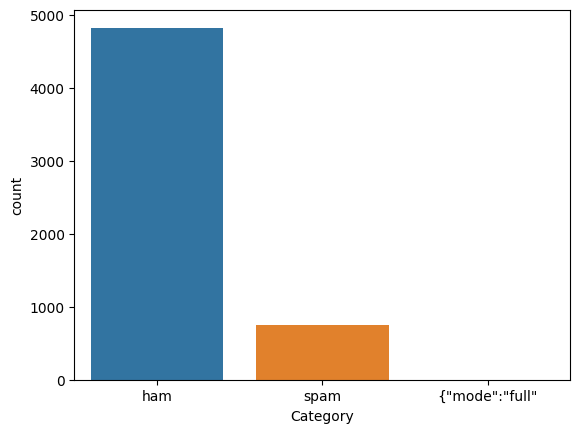

In [10]:
sns.countplot(x='Category', data=mails)
plt.show()

**Text Preprocessing**

* Stop word removal 
* punctuation removal
* stemming or lemmatization


These are need to be done so that text can be tokenized and use it train model

In [11]:
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
mails['Message'] = mails['Message'].str.replace('Subject','')
mails.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
punc_list = string.punctuation

def remove_punc(text):
    temp = str.maketrans('', '', punc_list)
    return text.translate(temp)

mails['Message'] = mails['Message'].apply(lambda x:remove_punc(x))
mails.head()

,Category,Message
0,ham,Go until jurong point crazy Available only in ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor U c already then say
4,ham,Nah I dont think he goes to usf he lives aroun...


In [14]:
def cate_bin(txt):
    if(txt == 'spam'):
        return 0
    else:
        return 1

mails['Category'] = mails['Category'].apply(lambda x:cate_bin(x))
mails.head()

,Category,Message
0,1,Go until jurong point crazy Available only in ...
1,1,Ok lar Joking wif u oni
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor U c already then say
4,1,Nah I dont think he goes to usf he lives aroun...


In [15]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
        word = word.lower()
 
        if word not in stop_words:
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output

mails['Message'] = mails['Message'].apply(lambda x: remove_stopwords(x))
mails.head()

,Category,Message
0,1,go jurong point crazy available bugis n great ...
1,1,ok lar joking wif u oni
2,0,free entry 2 wkly comp win fa cup final tkts 2...
3,1,u dun say early hor u c already say
4,1,nah dont think goes usf lives around though


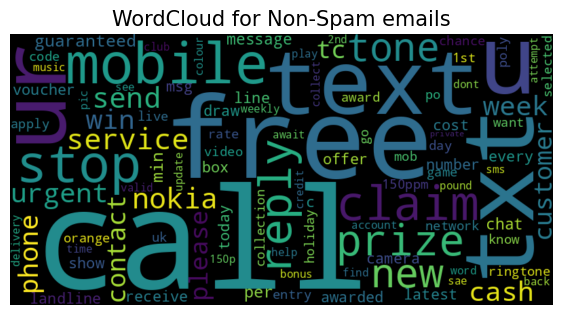

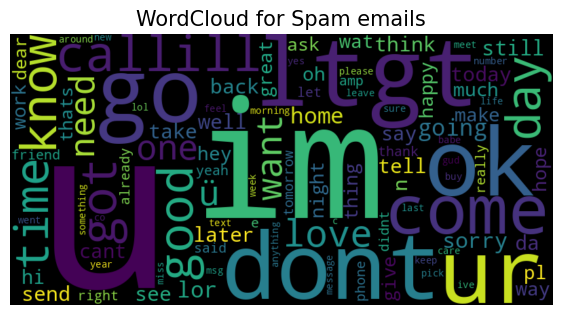

In [16]:

def plot_cloud(data, typ):
    email_corpus = " ".join(data['Message'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_cloud(mails[mails['Category'] == 0], typ='Non-Spam')
plot_cloud(mails[mails['Category'] == 1], typ='Spam')

**Word2Vec conversion**

We cannot feed sentences to the machine learning models beacause they only work with numbers only. Hence we convert our words into **Token ID** and then feed the model with our data

In [17]:
#all modules required for training and modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [18]:
train_x, test_x, train_y, test_y = train_test_split(mails['Message'],mails['Category'],test_size = 0.2, random_state = 42)

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)

# Convert text to consequences
train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)

# Pad sequences to have the same length
max_len = 100
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len, 
                                padding='post', 
                                truncating='post')
test_sequences = pad_sequences(test_sequences, 
                               maxlen=max_len, 
                               padding='post', 
                               truncating='post')

**Model Development** 

We implement sequential model
* Three Embedding layers
* An Long short term memory (LSTM) layer - to identify pattern
* One fully connected layer
* Output layer which outputs probabilities for the two classes

In [25]:
# Adding all listed model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 32, input_length = max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

# Printing a summary of models
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Compiling Model**

parameters = loss, metrics, optimizer

In [26]:

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

**Optional - Callback**

Callbacks are special utilities that allow you to monitor and respond to various events during the training process. They can be used to execute custom code at certain points, such as at the start or end of an epoch, batch, or when certain conditions are met.

In [27]:
es = EarlyStopping(patience=3,monitor = 'val_accuracy',restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,monitor = 'val_loss',factor = 0.5,verbose = 0)

Training Model

In [29]:
history = model.fit(train_sequences, train_y, validation_data = (test_sequences,test_y),epochs=20,batch_size=32,callbacks = [lr,es])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8484 - loss: 0.4595 - val_accuracy: 0.8592 - val_loss: 0.4065 - learning_rate: 0.0010
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8654 - loss: 0.3954 - val_accuracy: 0.8592 - val_loss: 0.4077 - learning_rate: 0.0010
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8715 - loss: 0.3854 - val_accuracy: 0.8592 - val_loss: 0.4064 - learning_rate: 0.0010
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8568 - loss: 0.4110 - val_accuracy: 0.8592 - val_loss: 0.4075 - learning_rate: 5.0000e-04


**Evaluvating the model**

In [30]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8419 - loss: 0.4373
Test Loss : 0.40650299191474915
Test Accuracy : 0.8591928482055664


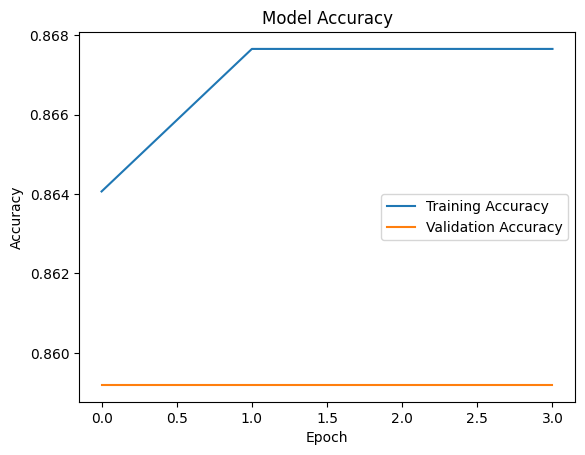

In [31]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()